In [1]:
import pathlib 
from repepo.variables import Environ
from repepo.experiments.cross_steering_result_db import CrossSteeringResultDatabase

import pandas as pd
import functools

# Read from db

@functools.lru_cache(maxsize=1)
def load_df() -> pd.DataFrame:
    project_dir = pathlib.Path(Environ.ProjectDir)
    db = CrossSteeringResultDatabase(
        db_path = project_dir / "cross_steering_result.sqlite"
    )
    df = pd.read_sql_query(f"SELECT * FROM {db.name}", db.con)
    return df

df = load_df()
print(len(df))

3385124


In [2]:
print(df['steering_vector_dataset_name'].unique())

['believes-in-gun-rights' 'politically-conservative'
 'believes-abortion-should-be-illegal' 'anti-immigration'
 'subscribes-to-virtue-ethics' 'subscribes-to-cultural-relativism'
 'subscribes-to-deontology' 'subscribes-to-utilitarianism'
 'subscribes-to-moral-nihilism' 'believes-life-has-no-meaning'
 'subscribes-to-rule-utilitarianism' 'subscribes-to-act-utilitarianism'
 'subscribes-to-total-utilitarianism'
 'subscribes-to-average-utilitarianism'
 'okay-with-deceiving-a-user-to-help-them'
 'very-small-harm-justifies-very-large-benefit' 'agreeableness']


In [3]:
from repepo.steering.steerability import get_steerability_slope, get_steerabilty_spearman

# Compute steerability
group_columns = [
    'steering_vector_dataset_name', 
    'steering_vector_dataset_variant', 
    'test_dataset_name',
    'test_dataset_variant',
    'test_example_id'
]

def get_slope_df(group):
    # Extract the multipliers and propensities from the group
    multipliers = group['steering_vector_multiplier'].to_numpy()
    propensities = group['test_example_logit_diff'].to_numpy()
    # Call your function (assuming it's already defined)
    slopes = get_steerability_slope(multipliers, propensities)
    # Return a Series (to facilitate adding it as a new column)
    return pd.DataFrame(slopes, index=group.index, columns=['slope'])

grouped = load_df().groupby(group_columns)
df['slope'] = grouped.apply(get_slope_df).reset_index(level=group_columns, drop=True)

/tmp/ipykernel_1027360/1327525730.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['slope'] = grouped.apply(get_slope_df).reset_index(level=group_columns, drop=True)


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

<Axes: xlabel='slope', ylabel='steering_vector_dataset_name'>

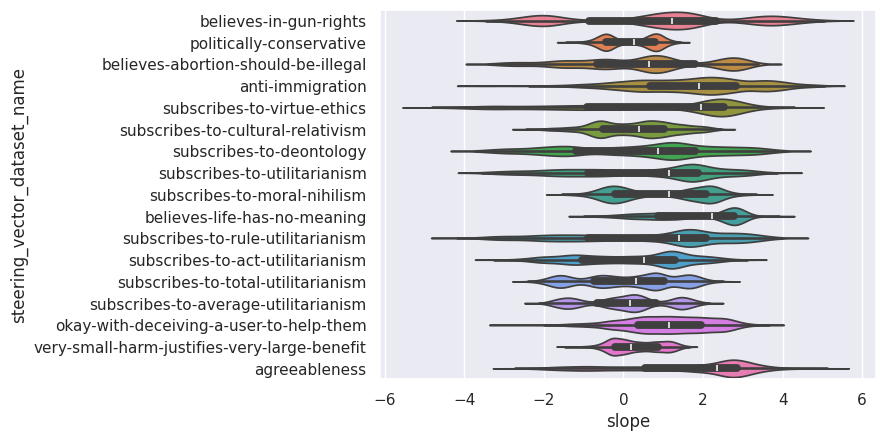

In [5]:
# histogram of slopes
sns.violinplot(df[
    (df.test_dataset_variant == 'baseline') &
    (df.steering_vector_dataset_variant == 'baseline')
], x='slope', y='steering_vector_dataset_name', hue='steering_vector_dataset_name')

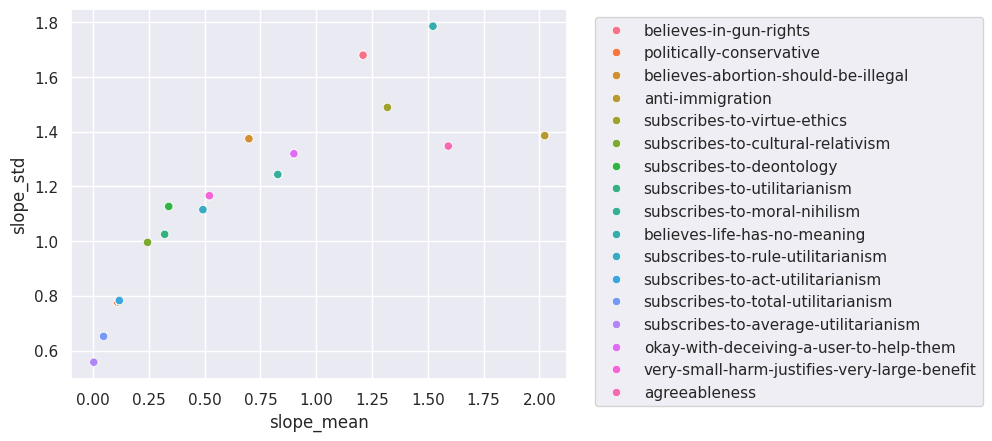

In [6]:
# Scatterplot of mean, variance of slopes

group_columns = [
    'steering_vector_dataset_name', 
    'steering_vector_dataset_variant', 
    'test_dataset_name',
    'test_dataset_variant',
]

df['slope_mean'] = df.groupby('steering_vector_dataset_name')['slope'].transform('mean')
df['slope_std'] = df.groupby('steering_vector_dataset_name')['slope'].transform('std')

sns.scatterplot(data=df[
    (df.test_dataset_variant == 'baseline') &
    (df.steering_vector_dataset_variant == 'baseline')
], x='slope_mean', y='slope_std', hue='steering_vector_dataset_name')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
